In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
IMAGE_PATH = 'E:/Padmapriya/Datasets/new/im/'
MASK_PATH = 'E:/Padmapriya/Datasets/new/ma/'

In [5]:
n_classes = 150

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  86


In [6]:
#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  65
Val Size     :  12
Test Size    :  9


Image Size (600, 800, 3)
Mask Size (600, 800, 3)


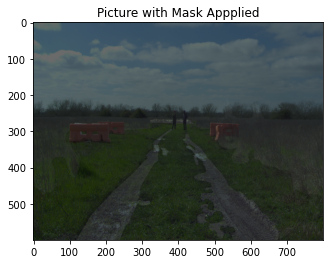

In [7]:
img = Image.open(IMAGE_PATH + df['id'][25]+'.jpg')
mask = Image.open(MASK_PATH + df['id'][25]+'.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()


In [8]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
             img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches
   

In [9]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 3 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True) 

In [10]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=150, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

In [11]:
model

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), 

In [12]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [13]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=20):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [14]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0
    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [14]:
pip install --upgrade numpy==1.19.5

  Using cached numpy-1.19.5.zip (7.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  Preparing metadata (pyproject.toml) did not run successfully.
  exit code: 1
  
  [275 lines of output]
  setup.py:67: RuntimeWarning: NumPy 1.19.5 may not yet support Python 3.10.
    warnings.warn(
  Running from numpy source directory.
  setup.py:480: UserWarning: Unrecognized setuptools command, proceeding with generating Cython sources and expanding templates
    run_build = parse_setuppy_commands()
  Processing numpy/random\_bounded_integers.pxd.in
  Processing numpy/random\bit_generator.pyx
  Processing numpy/random\mtrand.pyx
  Processing numpy/random\_bounded_integers.pyx.in
  Processing numpy/random\_common.pyx
  Processing numpy/random\_generator.pyx
  Processing numpy/random\_mt19937.pyx
  Processing numpy/random\_pcg64.pyx
  Processing numpy/random\_philox.pyx
  Processing numpy/random\_sfc64.pyx
  Cythonizing sources
  blas_opt_info:
  blas_mkl_info:
  No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying fro

In [15]:
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 4.288 
Epoch:1/15.. Train Loss: 4.882.. Val Loss: 4.288.. Train mIoU:0.010.. Val mIoU: 0.056.. Train Acc:0.054.. Val Acc:0.319.. Time: 7.98m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Loss Decreasing.. 4.288 >> 2.926 
Epoch:2/15.. Train Loss: 4.230.. Val Loss: 2.926.. Train mIoU:0.086.. Val mIoU: 0.143.. Train Acc:0.453.. Val Acc:0.812.. Time: 8.27m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Loss Decreasing.. 2.926 >> 1.811 
Epoch:3/15.. Train Loss: 2.932.. Val Loss: 1.811.. Train mIoU:0.146.. Val mIoU: 0.155.. Train Acc:0.798.. Val Acc:0.857.. Time: 8.03m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Loss Decreasing.. 1.811 >> 1.146 
saving model...
Epoch:4/15.. Train Loss: 1.610.. Val Loss: 1.146.. Train mIoU:0.138.. Val mIoU: 0.126.. Train Acc:0.783.. Val Acc:0.783.. Time: 8.16m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Loss Decreasing.. 1.146 >> 0.690 
Epoch:5/15.. Train Loss: 0.900.. Val Loss: 0.690.. Train mIoU:0.150.. Val mIoU: 0.159.. Train Acc:0.825.. Val Acc:0.852.. Time: 8.29m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Loss Decreasing.. 0.690 >> 0.528 
Epoch:6/15.. Train Loss: 0.722.. Val Loss: 0.528.. Train mIoU:0.151.. Val mIoU: 0.164.. Train Acc:0.832.. Val Acc:0.869.. Time: 8.09m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Loss Decreasing.. 0.528 >> 0.444 
Epoch:7/15.. Train Loss: 0.579.. Val Loss: 0.444.. Train mIoU:0.163.. Val mIoU: 0.168.. Train Acc:0.866.. Val Acc:0.903.. Time: 8.15m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Loss Decreasing.. 0.444 >> 0.429 
Epoch:8/15.. Train Loss: 0.527.. Val Loss: 0.429.. Train mIoU:0.166.. Val mIoU: 0.167.. Train Acc:0.870.. Val Acc:0.896.. Time: 8.19m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Loss Decreasing.. 0.429 >> 0.389 
saving model...
Epoch:9/15.. Train Loss: 0.474.. Val Loss: 0.389.. Train mIoU:0.168.. Val mIoU: 0.174.. Train Acc:0.880.. Val Acc:0.911.. Time: 8.10m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:10/15.. Train Loss: 0.468.. Val Loss: 0.413.. Train mIoU:0.169.. Val mIoU: 0.170.. Train Acc:0.878.. Val Acc:0.899.. Time: 7.94m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Loss Decreasing.. 0.413 >> 0.383 
Epoch:11/15.. Train Loss: 0.470.. Val Loss: 0.383.. Train mIoU:0.169.. Val mIoU: 0.174.. Train Acc:0.883.. Val Acc:0.905.. Time: 8.17m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Loss Decreasing.. 0.383 >> 0.377 
Epoch:12/15.. Train Loss: 0.446.. Val Loss: 0.377.. Train mIoU:0.170.. Val mIoU: 0.169.. Train Acc:0.880.. Val Acc:0.903.. Time: 8.17m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Loss Decreasing.. 0.377 >> 0.362 
Epoch:13/15.. Train Loss: 0.443.. Val Loss: 0.362.. Train mIoU:0.170.. Val mIoU: 0.174.. Train Acc:0.886.. Val Acc:0.913.. Time: 8.29m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Loss Decreasing.. 0.362 >> 0.345 
Epoch:14/15.. Train Loss: 0.402.. Val Loss: 0.345.. Train mIoU:0.174.. Val mIoU: 0.176.. Train Acc:0.899.. Val Acc:0.918.. Time: 7.95m


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:15/15.. Train Loss: 0.424.. Val Loss: 0.349.. Train mIoU:0.171.. Val mIoU: 0.177.. Train Acc:0.893.. Val Acc:0.916.. Time: 7.91m
Total time: 121.69 m


In [16]:
torch.save(model, 'Unet-Mobilenet.pt')

In [17]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

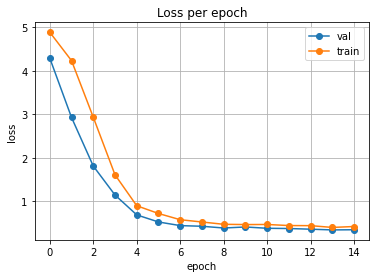

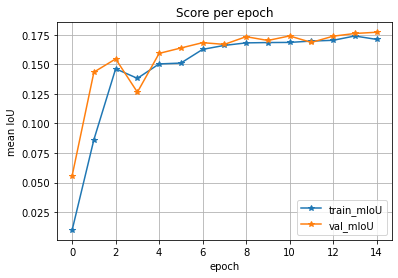

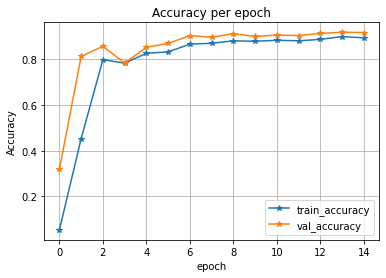

In [18]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [19]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [20]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [21]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [22]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [23]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [24]:
mob_miou = miou_score(model, test_set)

  0%|          | 0/9 [00:00<?, ?it/s]

In [25]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [26]:
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/9 [00:00<?, ?it/s]

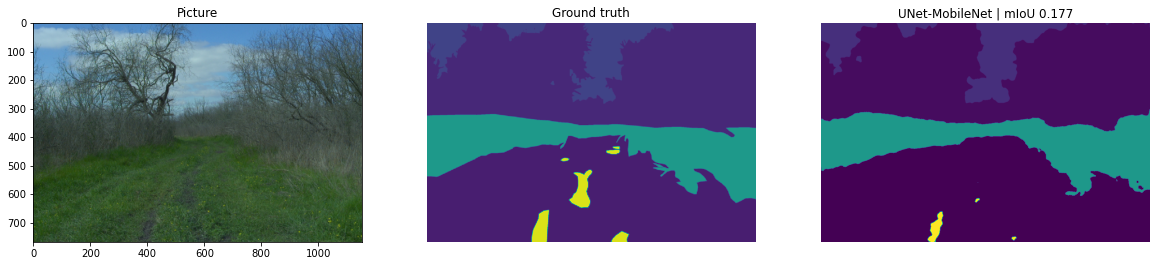

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

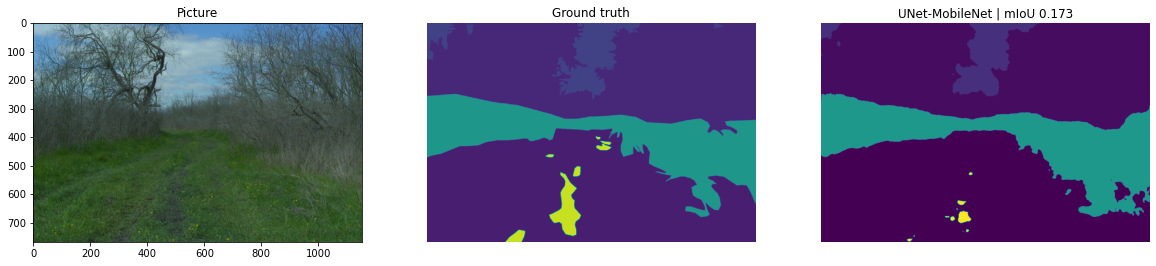

In [28]:
image2, mask2 = test_set[4]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

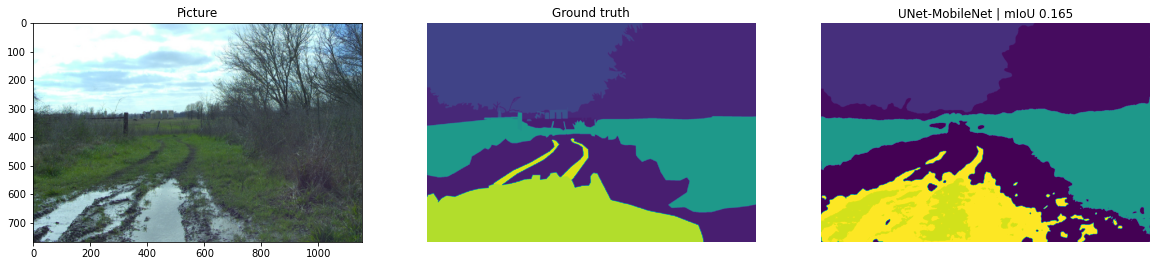

In [31]:
image3, mask3 = test_set[8]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [32]:
print('Test Set mIoU', np.mean(mob_miou))

Test Set mIoU 0.17586302876146545


In [33]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set Pixel Accuracy 0.8841846607349537
